## Task- 3

Begin by exploring the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/siren.ipynb) that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:
    
1.  Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) **[3 Marks]**

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:  **[1 Marks]**
    - RMSE on predicted v/s ground truth high resolution image
    - Peak SNR on predicted v/s ground truth high resolution image 

Follow the below steps to execute this task:
- Start with a 400x400 high-resolution image (the original image).
- Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: [OpenCV Resize Image Tutorial](https://docs.google.com/document/d/1Gz9pl8nvzqOq8huGGgWnEwzPUJbMU8mC/edit).
- Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
- Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
- Compare your predicted 400x400 image with the original 400x400 high-resolution image.
- Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.


### Question-1 : Demonstrate the following applications using the cropped image from the notebook. Super-resolution: Perform supe resolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) 

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import cv2
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import crop as torchvision_crop
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [3]:
# Demonstrate the following applications using the cropped image from the notebook. Super-resolution: Perform supe resolution on the image shown in notebook to enhance its resolution by factor 2.
# Need to use random fourier features. 
# take an image 1.jpg and crop it 
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg


dog.jpg exists


In [4]:
# read the image 
img = torchvision.io.read_image("dog.jpg")
print(img.shape)


torch.Size([3, 1365, 2048])


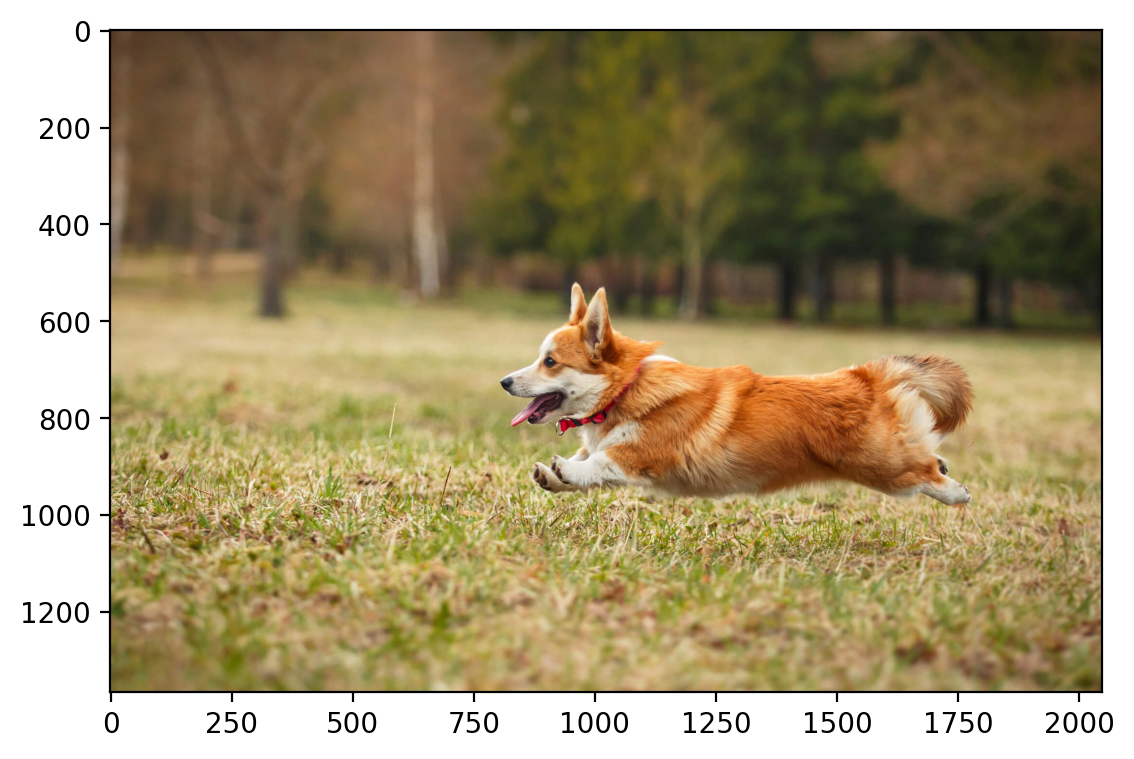

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


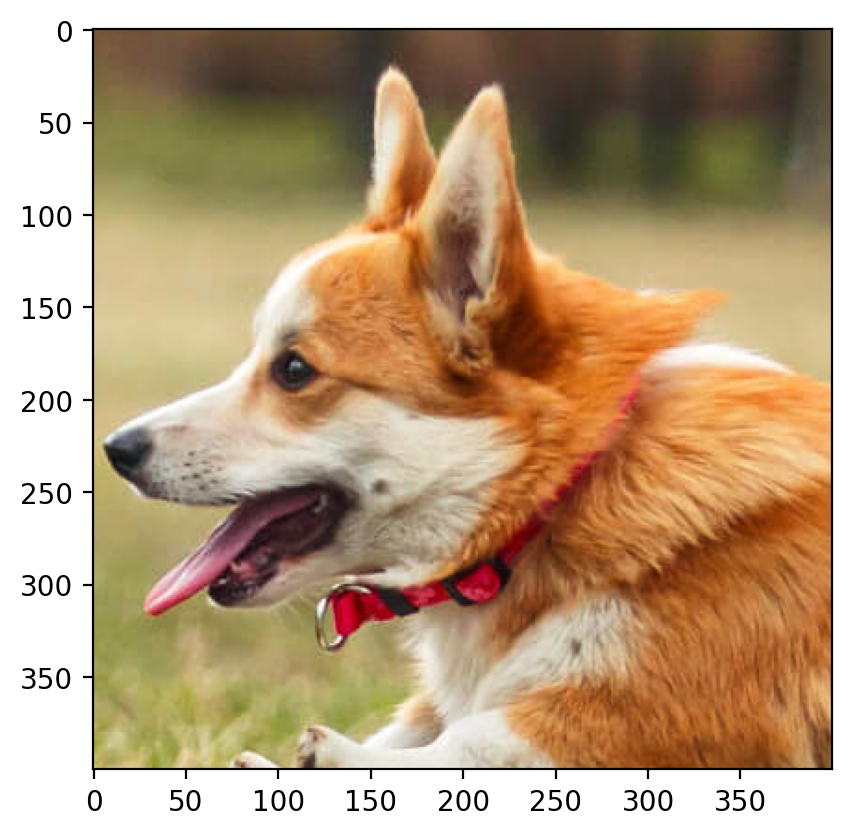

In [34]:

# STEP - 1 
from sklearn import preprocessing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 400, 400)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

# use pil library and save the image
from PIL import Image
crop = rearrange(crop, 'c h w -> h w c').cpu().numpy()
crop = (crop * 255).astype(np.uint8)
crop = Image.fromarray(crop)
crop.save('crop_res.jpg')



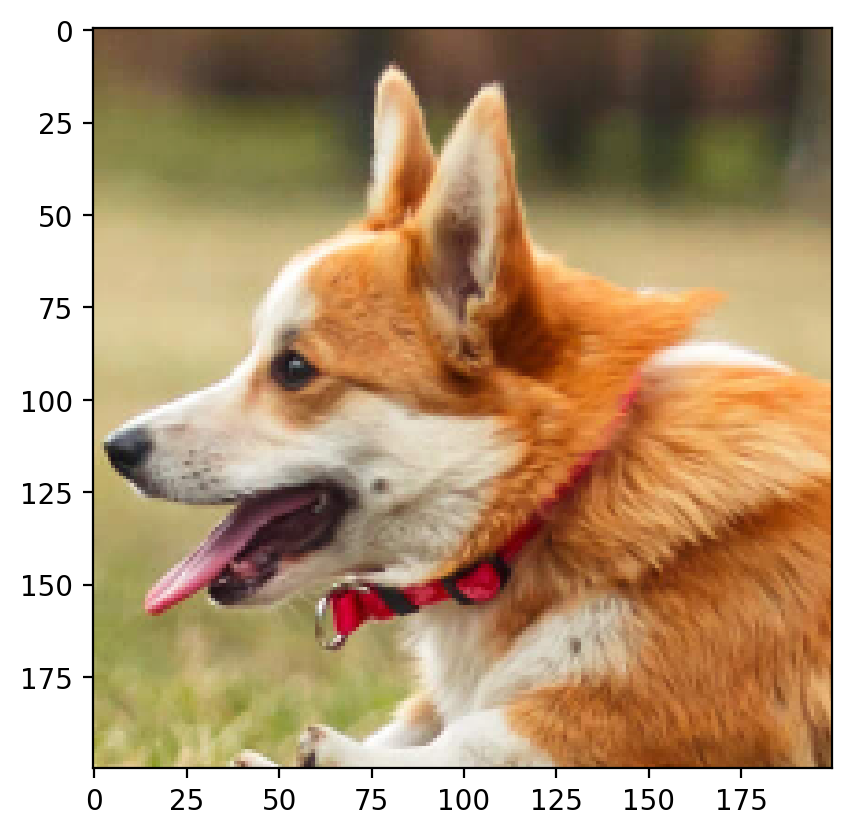

In [42]:
# Step - 2

import cv2

# Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this.
crop_np = np.array(crop)  # This will create an array in shape [H, W, C]

# Resize the image using OpenCV
crop_resized = cv2.resize(crop_np, (200, 200))

# Display the resized image
plt.imshow(crop_resized) 
  # Optional: hide axes
plt.show()


In [49]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [50]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [55]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 200, 200)
crop.shape


torch.Size([3, 200, 200])

In [57]:
dog_X, dog_Y = create_coordinate_map(crop)

print(dog_X.shape, dog_Y.shape)

print(dog_X)
print(dog_Y)

torch.Size([40000, 2]) torch.Size([40000, 3])
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]], device='cuda:0')
tensor([[0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        ...,
        [0.4235, 0.0039, 0.0353],
        [0.5412, 0.0353, 0.0549],
        [0.6353, 0.0745, 0.0980]])


In [67]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

print(dog_X_scaled.shape)

torch.Size([40000, 2])


In [81]:
#Step - 3: Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
# Create a random Fourier feature object with 1000 features
# define random fourier features function for super resolution
class RandomFourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0):
        super(RandomFourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.weights = nn.Parameter(torch.randn(in_features, out_features) * scale)
        self.biases = nn.Parameter(torch.randn(out_features) * (2 * np.pi))
        
    def forward(self, x):
        # x: (num_samples, in_features)
        # weights: (in_features, out_features)
        # biases: (out_features)
        
        # x * weights: (num_samples, out_features)
        # x * weights + biases: (num_samples, out_features)
        return torch.cos(x @ self.weights + self.biases)
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, scale={self.scale}'
    
# Create a random Fourier feature object with 1000 features
rff = RandomFourierFeatures(in_features=2, out_features=1000, scale=1.0).to(device)

# Apply the random Fourier features to the scaled X coordinates



class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

In [82]:
dog_X_rff = rff(dog_X_scaled)

print(dog_X_rff.shape)

torch.Size([40000, 1000])


In [83]:

def train(net, lr, X, Y, epochs, device, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    device: torch.device (either 'cpu' or 'cuda')
    """

    # Move data to the specified device
    X = X.to(device)
    Y = Y.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()


In [87]:
\


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [73]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


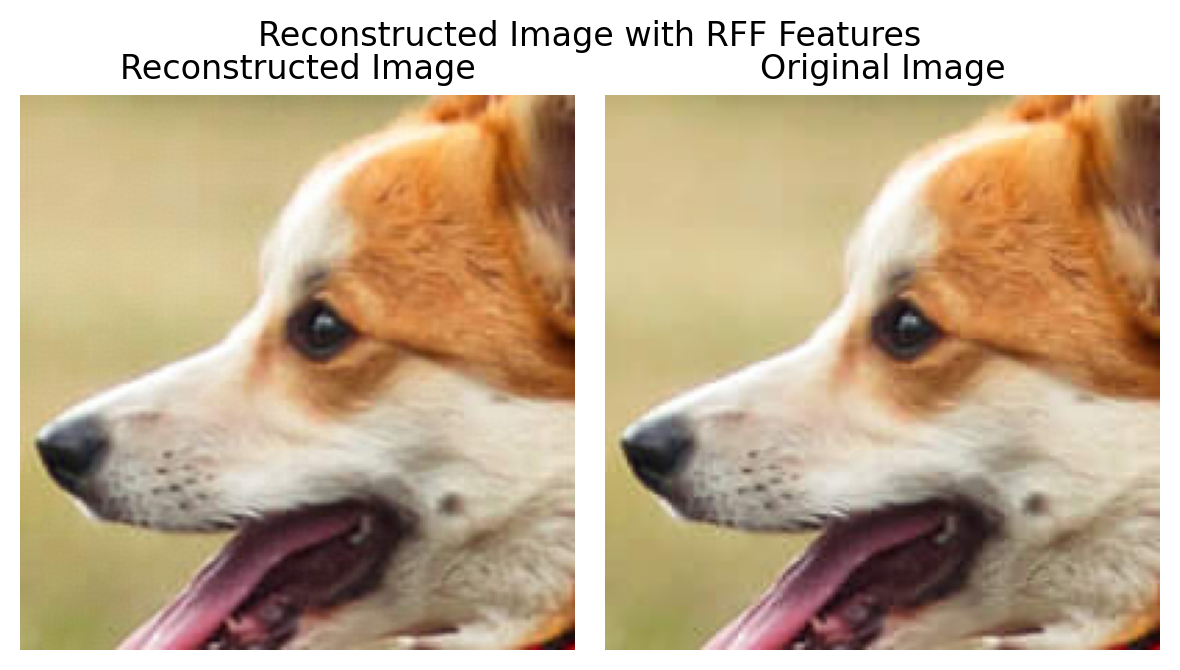

In [74]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

### Question- 2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:  **[1 Marks]**- RMSE on predicted v/s ground truth high resolution image - Peak SNR on predicted v/s ground truth high resolution image 

In [79]:
# calculate rmse on predicted v/s truth high resolution image.
def calculate_rmse(original_img, net, X):
    num_channels, height, width 
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        outputs = outputs.permute(2, 0, 1)
        mse = nn.MSELoss()
        rmse = torch.sqrt(mse(original_img, outputs))
    return rmse.item()

# print the rmse value
rmse = calculate_rmse(crop, net, X_rff)
print(f"RMSE: {rmse:.6f}")

RuntimeError: shape '[3, 4, 2]' is invalid for input of size 120000

In [ ]:
#